In [48]:
# I made training on my notebook without nvidia gpu. 
#It took me 18h, but it is better than free died collab.

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive/')

In [74]:
torch.cuda.is_available()

False

In [6]:
import pickle
import numpy as np
!pip install scikit-image
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [7]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


In [8]:
class SimpsonsDataset(Dataset):
  
    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
    
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        data_transforms = transforms.Compose([
        transforms.ToTensor(),
        #transforms.RandomGrayscale(p=0.1),
        #transforms.RandomAffine(degrees = 20),
        #transforms.RandomPerspective(),
        #transforms.RandomErasing(),     
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        if self.mode == 'train':
          x = data_transforms(x)
        else:
          x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [9]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow for tensors"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [10]:
TRAIN_DIR = Path('./journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('./journey-springfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [11]:
len(train_val_files)

20933

In [12]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)
# TRAIN_DIR = Path(r'../input/journey-springfield/train/simpsons_dataset')
# TEST_DIR = Path(r'../input/journey-springfield/testset/testset')

# train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
# test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
# train_val_labels = [path.parent.name for path in train_val_files]

In [13]:
train_val_files = []
d ={}
for i in train_val_labels:
  if i in d:
    d[i] += 1
  else:
    d[i] = 1


for i in d:
  f_path = Path(f'./journey-springfield/train/simpsons_dataset/{i}')
  train_val_files.extend(list(f_path.rglob('*.jpg'))* (2246//d[i]))

len(train_val_files)

83248

In [14]:
d

{'abraham_grampa_simpson': 913,
 'agnes_skinner': 42,
 'apu_nahasapeemapetilon': 623,
 'barney_gumble': 106,
 'bart_simpson': 1342,
 'carl_carlson': 98,
 'charles_montgomery_burns': 1193,
 'chief_wiggum': 986,
 'cletus_spuckler': 47,
 'comic_book_guy': 469,
 'disco_stu': 8,
 'edna_krabappel': 457,
 'fat_tony': 27,
 'gil': 27,
 'groundskeeper_willie': 121,
 'homer_simpson': 2246,
 'kent_brockman': 498,
 'krusty_the_clown': 1206,
 'lenny_leonard': 310,
 'lionel_hutz': 3,
 'lisa_simpson': 1354,
 'maggie_simpson': 128,
 'marge_simpson': 1291,
 'martin_prince': 71,
 'mayor_quimby': 246,
 'milhouse_van_houten': 1079,
 'miss_hoover': 17,
 'moe_szyslak': 1452,
 'ned_flanders': 1454,
 'nelson_muntz': 358,
 'otto_mann': 32,
 'patty_bouvier': 72,
 'principal_skinner': 1194,
 'professor_john_frink': 65,
 'rainier_wolfcastle': 45,
 'ralph_wiggum': 89,
 'selma_bouvier': 103,
 'sideshow_bob': 877,
 'sideshow_mel': 40,
 'snake_jailbird': 55,
 'troy_mcclure': 8,
 'waylon_smithers': 181}

In [15]:
42 * 2246

94332

In [16]:
len(d)

42

In [18]:
val_dataset = SimpsonsDataset(val_files, mode='val')

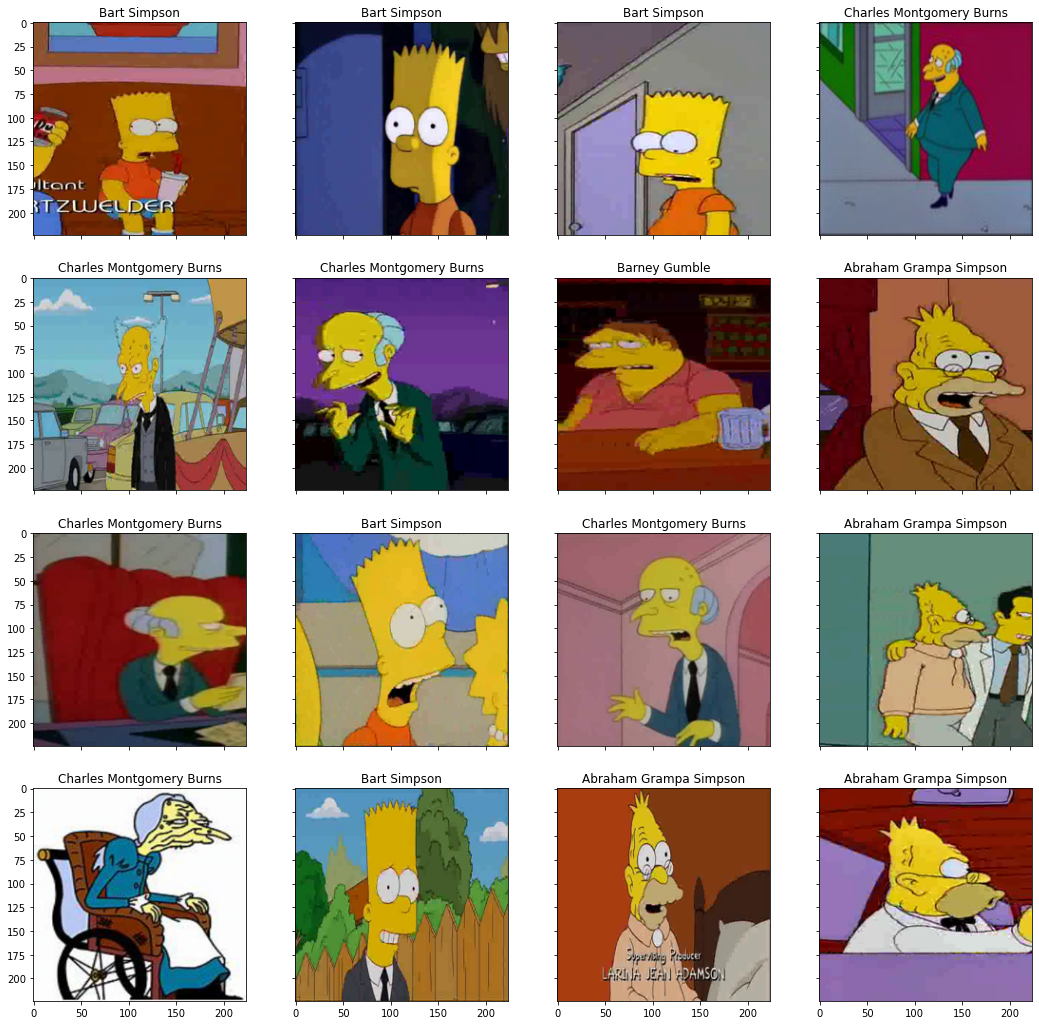

In [19]:
fig, ax = plt.subplots(nrows=4, ncols=4,figsize=(18, 18), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [20]:

class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [21]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs
        # inputs = inputs.to(DEVICE)
        # labels = labels.to(DEVICE)
        labels = labels
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [22]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        # inputs = inputs.to(DEVICE)
        inputs = inputs
        # labels = labels.to(DEVICE)
        labels = labels

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [23]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [24]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs
            # inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [25]:
import torchvision.models as models
n_classes = len(np.unique(train_val_labels))


In [26]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes)
# simple_cnn = SimpleCnn(n_classes).to(DEVICE)
#simple_cnn = simple_cnn.to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

In [27]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [28]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=30, batch_size=256)

epoch:   0%|                                             | 0/30 [00:00<?, ?it/s]

loss 3.1450687458472797


epoch:   3%|█▏                                | 1/30 [06:02<2:55:05, 362.25s/it]


Epoch 001 train_loss: 3.1451     val_loss 3.0101 train_acc 0.1069 val_acc 0.1244
loss 2.799334016557909


epoch:   7%|██▎                               | 2/30 [12:06<2:49:30, 363.24s/it]


Epoch 002 train_loss: 2.7993     val_loss 2.6586 train_acc 0.2006 val_acc 0.2476
loss 2.5022453189131575


epoch:  10%|███▍                              | 3/30 [18:04<2:42:30, 361.13s/it]


Epoch 003 train_loss: 2.5022     val_loss 2.3531 train_acc 0.2943 val_acc 0.3416
loss 2.170948035428916


epoch:  13%|████▌                             | 4/30 [23:40<2:32:09, 351.15s/it]


Epoch 004 train_loss: 2.1709     val_loss 2.0836 train_acc 0.3959 val_acc 0.4306
loss 1.8476152334921572


epoch:  17%|█████▋                            | 5/30 [29:40<2:27:32, 354.11s/it]


Epoch 005 train_loss: 1.8476     val_loss 1.7900 train_acc 0.4939 val_acc 0.5147
loss 1.5796618851759425


epoch:  20%|██████▊                           | 6/30 [35:29<2:20:58, 352.45s/it]


Epoch 006 train_loss: 1.5797     val_loss 1.5943 train_acc 0.5686 val_acc 0.5747
loss 1.3892915916485393


epoch:  23%|███████▉                          | 7/30 [41:36<2:16:58, 357.33s/it]


Epoch 007 train_loss: 1.3893     val_loss 1.4616 train_acc 0.6189 val_acc 0.6085
loss 1.2229488708462803


epoch:  27%|█████████                         | 8/30 [48:35<2:18:09, 376.80s/it]


Epoch 008 train_loss: 1.2229     val_loss 1.3527 train_acc 0.6663 val_acc 0.6517
loss 1.1023749272734795


epoch:  30%|██████████▏                       | 9/30 [55:54<2:18:44, 396.40s/it]


Epoch 009 train_loss: 1.1024     val_loss 1.2459 train_acc 0.6964 val_acc 0.6762
loss 1.018438478067913


epoch:  33%|██████████▎                    | 10/30 [1:02:51<2:14:11, 402.58s/it]


Epoch 010 train_loss: 1.0184     val_loss 1.2521 train_acc 0.7186 val_acc 0.6718
loss 0.9526755596788167


epoch:  37%|███████████▎                   | 11/30 [1:09:15<2:05:45, 397.14s/it]


Epoch 011 train_loss: 0.9527     val_loss 1.1449 train_acc 0.7350 val_acc 0.7075
loss 0.8874729832567768


epoch:  40%|████████████▍                  | 12/30 [1:15:11<1:55:21, 384.55s/it]


Epoch 012 train_loss: 0.8875     val_loss 1.1047 train_acc 0.7563 val_acc 0.7142
loss 0.8191146840562608


epoch:  43%|█████████████▍                 | 13/30 [1:21:13<1:46:59, 377.59s/it]


Epoch 013 train_loss: 0.8191     val_loss 1.1075 train_acc 0.7718 val_acc 0.7121
loss 0.7863980605538632


epoch:  47%|██████████████▍                | 14/30 [1:27:10<1:39:03, 371.45s/it]


Epoch 014 train_loss: 0.7864     val_loss 1.1139 train_acc 0.7836 val_acc 0.7180
loss 0.7435321063667021


epoch:  50%|███████████████▌               | 15/30 [1:33:41<1:34:22, 377.51s/it]


Epoch 015 train_loss: 0.7435     val_loss 1.0181 train_acc 0.7918 val_acc 0.7382
loss 0.7024325008748922


epoch:  53%|████████████████▌              | 16/30 [1:40:47<1:31:26, 391.88s/it]


Epoch 016 train_loss: 0.7024     val_loss 1.0238 train_acc 0.8015 val_acc 0.7426
loss 0.6457848761884929


epoch:  57%|█████████████████▌             | 17/30 [1:47:43<1:26:31, 399.31s/it]


Epoch 017 train_loss: 0.6458     val_loss 0.9973 train_acc 0.8190 val_acc 0.7417
loss 0.613010113769234


epoch:  60%|██████████████████▌            | 18/30 [1:54:33<1:20:29, 402.48s/it]


Epoch 018 train_loss: 0.6130     val_loss 1.0258 train_acc 0.8281 val_acc 0.7503
loss 0.5948145910010717


epoch:  63%|███████████████████▋           | 19/30 [2:01:16<1:13:48, 402.61s/it]


Epoch 019 train_loss: 0.5948     val_loss 0.9769 train_acc 0.8338 val_acc 0.7574
loss 0.5615274404650228


epoch:  67%|████████████████████▋          | 20/30 [2:08:14<1:07:50, 407.07s/it]


Epoch 020 train_loss: 0.5615     val_loss 1.0083 train_acc 0.8423 val_acc 0.7505
loss 0.5344155519124361


epoch:  70%|█████████████████████▋         | 21/30 [2:15:14<1:01:38, 410.99s/it]


Epoch 021 train_loss: 0.5344     val_loss 0.9929 train_acc 0.8474 val_acc 0.7539
loss 0.5163758517344352


epoch:  73%|████████████████████████▏        | 22/30 [2:22:17<55:17, 414.74s/it]


Epoch 022 train_loss: 0.5164     val_loss 1.0018 train_acc 0.8519 val_acc 0.7556
loss 0.5113950047464734


epoch:  77%|█████████████████████████▎       | 23/30 [2:29:14<48:26, 415.23s/it]


Epoch 023 train_loss: 0.5114     val_loss 1.0001 train_acc 0.8541 val_acc 0.7589
loss 0.48411834455613184


epoch:  80%|██████████████████████████▍      | 24/30 [2:36:11<41:34, 415.79s/it]


Epoch 024 train_loss: 0.4841     val_loss 0.9672 train_acc 0.8605 val_acc 0.7713
loss 0.4469604232606026


epoch:  83%|███████████████████████████▌     | 25/30 [2:43:13<34:48, 417.65s/it]


Epoch 025 train_loss: 0.4470     val_loss 0.9981 train_acc 0.8730 val_acc 0.7581
loss 0.43062932989127894


epoch:  87%|████████████████████████████▌    | 26/30 [2:50:12<27:52, 418.12s/it]


Epoch 026 train_loss: 0.4306     val_loss 0.9810 train_acc 0.8781 val_acc 0.7726
loss 0.42374087170481156


epoch:  90%|█████████████████████████████▋   | 27/30 [2:57:13<20:57, 419.11s/it]


Epoch 027 train_loss: 0.4237     val_loss 0.9467 train_acc 0.8799 val_acc 0.7770
loss 0.3949652774689782


epoch:  93%|██████████████████████████████▊  | 28/30 [3:03:59<13:49, 414.95s/it]


Epoch 028 train_loss: 0.3950     val_loss 0.9562 train_acc 0.8867 val_acc 0.7803
loss 0.3893120617701435


epoch:  97%|███████████████████████████████▉ | 29/30 [3:10:40<06:50, 410.93s/it]


Epoch 029 train_loss: 0.3893     val_loss 0.9579 train_acc 0.8892 val_acc 0.7864
loss 0.37307619437821177


epoch: 100%|█████████████████████████████████| 30/30 [3:17:27<00:00, 394.92s/it]


Epoch 030 train_loss: 0.3731     val_loss 0.9955 train_acc 0.8903 val_acc 0.7847


In [29]:
torch.save(simple_cnn,'./journey-springfield/res50.pth')
torch.save(simple_cnn.state_dict(), './journey-springfield/res501.pth')

In [75]:
loss, acc, val_loss, val_acc = zip(*history)

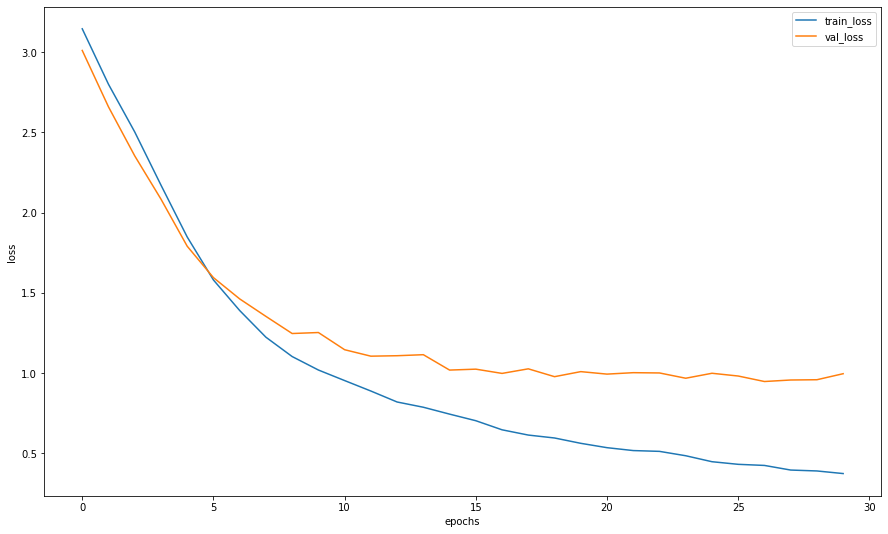

In [32]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [33]:
def predict_one_sample(model, inputs, device=DEVICE):
    """prediction for 1 picture"""
    with torch.no_grad():
        inputs = inputs
        # inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [34]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [35]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [36]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [37]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [38]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average='micro')


0.7

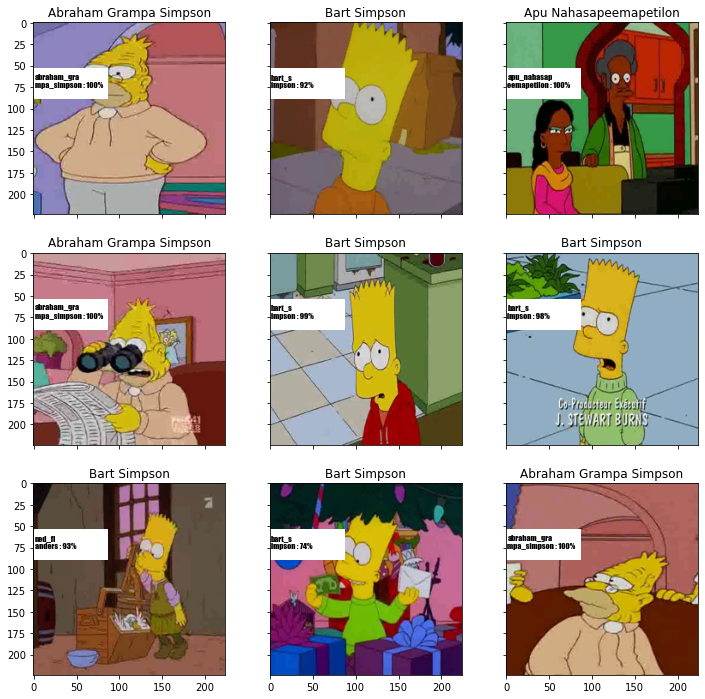

In [39]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit on Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [40]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [41]:
import pandas as pd
my_submit = pd.read_csv("./journey-springfield/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [43]:
my_submit.to_csv('./journey-springfield/simple_cnn_baseline_my.csv', index=False)

In [45]:
# My model to try is ResNet

model = models.resnet18(pretrained=True)

In [50]:
import torch.optim as optim

# freeze weights
for param in model.parameters():
    param.requires_grad = False

# modification of the last FC layer to fit our model
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, n_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())

scheduler = optim.lr_scheduler.StepLR(optimizer, 3, 0.5)

In [51]:
model.fc

Linear(in_features=512, out_features=42, bias=True)

In [57]:
def train(train_dataset, val_dataset, model, criterion,
          epochs, batch_size, optimizer, scheduler,
          shuffle=True, sampler=None):
    
    # if you want to make parallel calculations : add num of workers. I had attribute error, so decided not to use it.
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
            print(f"epoch {epoch+1}:\n")
            
            print("Fitting on train data...")
            # all arguments except train loader are from parameters passed to train() arguments
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            print("train loss:", train_loss)
            
            print("Evaluating on validation data...")
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            print("val loss:", train_loss)
            
            # record history
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            # update learning rate for the optimizer
            scheduler.step()
            
            # display learning status
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [58]:
history_feature_ext = train(train_dataset, val_dataset, model=model, criterion=criterion,
                             epochs=3, batch_size=256, optimizer=optimizer, scheduler=scheduler)

epoch:   0%|                                              | 0/3 [00:00<?, ?it/s]

epoch 1:

Fitting on train data...
train loss: 2.7511866734782497
Evaluating on validation data...


epoch:  33%|████████████                        | 1/3 [19:58<39:57, 1198.76s/it]

val loss: 2.7511866734782497

Epoch 001 train_loss: 2.7512     val_loss 2.2598 train_acc 0.2649 val_acc 0.4719
epoch 2:

Fitting on train data...
train loss: 2.0205161410142254
Evaluating on validation data...


epoch:  67%|████████████████████████            | 2/3 [39:09<19:30, 1170.76s/it]

val loss: 2.0205161410142254

Epoch 002 train_loss: 2.0205     val_loss 1.8158 train_acc 0.5281 val_acc 0.5694
epoch 3:

Fitting on train data...
train loss: 1.7016262560332989
Evaluating on validation data...


epoch: 100%|████████████████████████████████████| 3/3 [57:52<00:00, 1157.63s/it]

val loss: 1.7016262560332989

Epoch 003 train_loss: 1.7016     val_loss 1.5844 train_acc 0.5898 val_acc 0.6209


In [59]:
# pretrained model works, but also articles recommend fully train our model
# unfreeze the weights , make training for 25 epochs
for param in model.parameters():
    param.requires_grad = True

In [60]:
history_fine_tune = train(train_dataset=train_dataset, val_dataset=val_dataset, model=model, criterion=criterion,
                          epochs=25, batch_size=128, optimizer=optimizer, scheduler=scheduler)

epoch:   0%|                                             | 0/25 [00:00<?, ?it/s]

epoch 1:

Fitting on train data...
train loss: 3.41261834593759
Evaluating on validation data...


epoch:   4%|█▎                              | 1/25 [42:20<16:56:04, 2540.17s/it]

val loss: 3.41261834593759

Epoch 001 train_loss: 3.4126     val_loss 3.1066 train_acc 0.0978 val_acc 0.1108
epoch 2:

Fitting on train data...
train loss: 3.019764020174307
Evaluating on validation data...


epoch:   8%|██▍                           | 2/25 [1:25:12<16:20:56, 2558.97s/it]

val loss: 3.019764020174307

Epoch 002 train_loss: 3.0198     val_loss 2.9294 train_acc 0.1178 val_acc 0.1576
epoch 3:

Fitting on train data...
train loss: 2.8205387079607145
Evaluating on validation data...


epoch:  12%|███▌                          | 3/25 [2:09:44<15:57:15, 2610.70s/it]

val loss: 2.8205387079607145

Epoch 003 train_loss: 2.8205     val_loss 2.9416 train_acc 0.1879 val_acc 0.1901
epoch 4:

Fitting on train data...
train loss: 2.487285841710325
Evaluating on validation data...


epoch:  16%|████▊                         | 4/25 [2:55:32<15:32:43, 2664.95s/it]

val loss: 2.487285841710325

Epoch 004 train_loss: 2.4873     val_loss 2.4781 train_acc 0.3027 val_acc 0.3187
epoch 5:

Fitting on train data...
train loss: 2.1366333785015454
Evaluating on validation data...


epoch:  20%|██████                        | 5/25 [3:38:55<14:40:52, 2642.65s/it]

val loss: 2.1366333785015454

Epoch 005 train_loss: 2.1366     val_loss 1.8892 train_acc 0.4044 val_acc 0.4838
epoch 6:

Fitting on train data...
train loss: 1.6476903322874585
Evaluating on validation data...


epoch:  24%|███████▏                      | 6/25 [4:21:29<13:47:18, 2612.53s/it]

val loss: 1.6476903322874585

Epoch 006 train_loss: 1.6477     val_loss 1.5085 train_acc 0.5500 val_acc 0.5785
epoch 7:

Fitting on train data...
train loss: 1.199106091359245
Evaluating on validation data...


epoch:  28%|████████▍                     | 7/25 [5:05:29<13:06:27, 2621.51s/it]

val loss: 1.199106091359245

Epoch 007 train_loss: 1.1991     val_loss 1.1149 train_acc 0.6675 val_acc 0.6901
epoch 8:

Fitting on train data...
train loss: 1.0052592950426429
Evaluating on validation data...


epoch:  32%|█████████▌                    | 8/25 [5:51:15<12:33:56, 2660.95s/it]

val loss: 1.0052592950426429

Epoch 008 train_loss: 1.0053     val_loss 0.9988 train_acc 0.7228 val_acc 0.7302
epoch 9:

Fitting on train data...
train loss: 0.8652754012805898
Evaluating on validation data...


epoch:  36%|██████████▊                   | 9/25 [6:35:56<11:51:15, 2667.21s/it]

val loss: 0.8652754012805898

Epoch 009 train_loss: 0.8653     val_loss 0.9372 train_acc 0.7567 val_acc 0.7476
epoch 10:

Fitting on train data...
train loss: 0.6913588474272041
Evaluating on validation data...


epoch:  40%|███████████▌                 | 10/25 [7:20:07<11:05:34, 2662.33s/it]

val loss: 0.6913588474272041

Epoch 010 train_loss: 0.6914     val_loss 0.8282 train_acc 0.8071 val_acc 0.7835
epoch 11:

Fitting on train data...
train loss: 0.6129891028623838
Evaluating on validation data...


epoch:  44%|████████████▊                | 11/25 [8:03:14<10:15:51, 2639.36s/it]

val loss: 0.6129891028623838

Epoch 011 train_loss: 0.6130     val_loss 0.7570 train_acc 0.8271 val_acc 0.7961
epoch 12:

Fitting on train data...
train loss: 0.5631833675864608
Evaluating on validation data...


epoch:  48%|██████████████▍               | 12/25 [8:46:22<9:28:27, 2623.62s/it]

val loss: 0.5631833675864608

Epoch 012 train_loss: 0.5632     val_loss 0.6921 train_acc 0.8425 val_acc 0.8158
epoch 13:

Fitting on train data...
train loss: 0.4701627964988333
Evaluating on validation data...


epoch:  52%|███████████████▌              | 13/25 [9:28:53<8:40:19, 2601.60s/it]

val loss: 0.4701627964988333

Epoch 013 train_loss: 0.4702     val_loss 0.6388 train_acc 0.8705 val_acc 0.8317
epoch 14:

Fitting on train data...
train loss: 0.4423084942138349
Evaluating on validation data...


epoch:  56%|████████████████▏            | 14/25 [10:12:51<7:59:00, 2612.76s/it]

val loss: 0.4423084942138349

Epoch 014 train_loss: 0.4423     val_loss 0.6165 train_acc 0.8764 val_acc 0.8399
epoch 15:

Fitting on train data...
train loss: 0.4043064078078679
Evaluating on validation data...


epoch:  60%|█████████████████▍           | 15/25 [10:57:50<7:19:45, 2638.57s/it]

val loss: 0.4043064078078679

Epoch 015 train_loss: 0.4043     val_loss 0.6124 train_acc 0.8896 val_acc 0.8401
epoch 16:

Fitting on train data...
train loss: 0.367445755531867
Evaluating on validation data...


epoch:  64%|██████████████████▌          | 16/25 [11:41:37<6:35:16, 2635.16s/it]

val loss: 0.367445755531867

Epoch 016 train_loss: 0.3674     val_loss 0.5905 train_acc 0.8979 val_acc 0.8472
epoch 17:

Fitting on train data...
train loss: 0.35011837707730536
Evaluating on validation data...


epoch:  68%|███████████████████▋         | 17/25 [12:25:24<5:51:00, 2632.55s/it]

val loss: 0.35011837707730536

Epoch 017 train_loss: 0.3501     val_loss 0.5807 train_acc 0.9044 val_acc 0.8523
epoch 18:

Fitting on train data...
train loss: 0.33137541781076085
Evaluating on validation data...


epoch:  72%|████████████████████▉        | 18/25 [13:11:11<5:11:09, 2667.02s/it]

val loss: 0.33137541781076085

Epoch 018 train_loss: 0.3314     val_loss 0.5679 train_acc 0.9088 val_acc 0.8527
epoch 19:

Fitting on train data...
train loss: 0.3059660697337951
Evaluating on validation data...


epoch:  76%|██████████████████████       | 19/25 [13:55:52<4:27:07, 2671.27s/it]

val loss: 0.3059660697337951

Epoch 019 train_loss: 0.3060     val_loss 0.5619 train_acc 0.9167 val_acc 0.8569
epoch 20:

Fitting on train data...
train loss: 0.29833759719706304
Evaluating on validation data...


epoch:  80%|███████████████████████▏     | 20/25 [14:40:57<3:43:27, 2681.45s/it]

val loss: 0.29833759719706304

Epoch 020 train_loss: 0.2983     val_loss 0.5643 train_acc 0.9186 val_acc 0.8563
epoch 21:

Fitting on train data...
train loss: 0.2926335975188906
Evaluating on validation data...


epoch:  84%|████████████████████████▎    | 21/25 [15:26:09<2:59:22, 2690.67s/it]

val loss: 0.2926335975188906

Epoch 021 train_loss: 0.2926     val_loss 0.5625 train_acc 0.9202 val_acc 0.8588
epoch 22:

Fitting on train data...
train loss: 0.27798484412452446
Evaluating on validation data...


epoch:  88%|█████████████████████████▌   | 22/25 [16:11:16<2:14:46, 2695.40s/it]

val loss: 0.27798484412452446

Epoch 022 train_loss: 0.2780     val_loss 0.5611 train_acc 0.9239 val_acc 0.8584
epoch 23:

Fitting on train data...
train loss: 0.27663622132300025
Evaluating on validation data...


epoch:  92%|██████████████████████████▋  | 23/25 [16:56:29<1:30:01, 2700.63s/it]

val loss: 0.27663622132300025

Epoch 023 train_loss: 0.2766     val_loss 0.5610 train_acc 0.9238 val_acc 0.8609
epoch 24:

Fitting on train data...
train loss: 0.269934127599056
Evaluating on validation data...


epoch:  96%|█████████████████████████████▊ | 24/25 [17:41:41<45:04, 2704.01s/it]

val loss: 0.269934127599056

Epoch 024 train_loss: 0.2699     val_loss 0.5555 train_acc 0.9266 val_acc 0.8619
epoch 25:

Fitting on train data...
train loss: 0.2648495934688633
Evaluating on validation data...


epoch: 100%|███████████████████████████████| 25/25 [18:26:51<00:00, 2656.46s/it]

val loss: 0.2648495934688633

Epoch 025 train_loss: 0.2648     val_loss 0.5576 train_acc 0.9274 val_acc 0.8640


In [61]:
loss, acc, val_loss, val_acc = zip(*history_fine_tune)

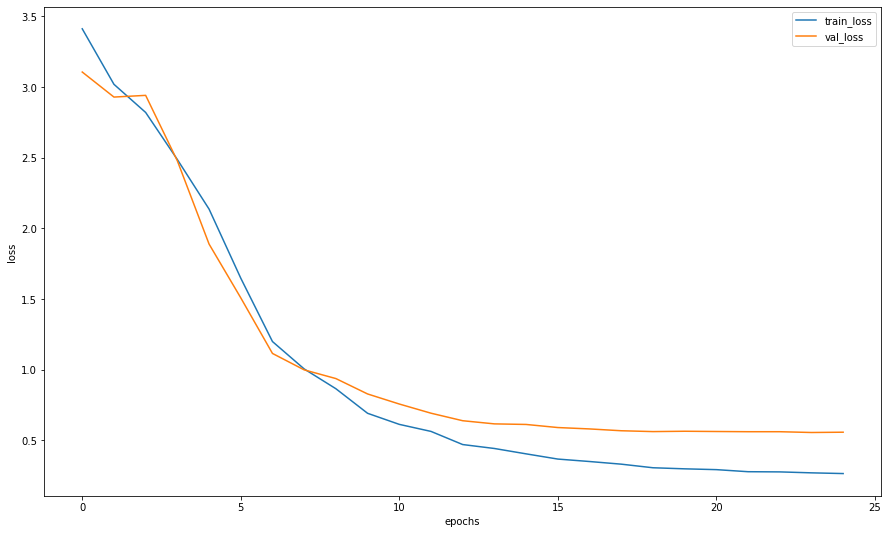

In [62]:
# plot the results curves

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


In [64]:
# save model weights
import copy
model_25epoch_weights = copy.deepcopy(model.state_dict())
torch.save(model_25epoch_weights, "model_25epoch_weights.pth")

In [69]:
# make prediction
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [71]:
import pandas as pd
sample_submit = pd.read_csv("./journey-springfield/sample_submission.csv")
sample_submit.head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [72]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
print(my_submit.shape)
my_submit.head()

(991, 2)


,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [73]:
# save submit
my_submit.to_csv('resnet_submission.csv', index=False)

In [76]:
# I got sad 0.91 score on Kaggle =(